# Denoising Diffusion Probabilistic Models (DDPM)

[Paper here](https://arxiv.org/pdf/2006.11239)


In [1]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich


In [2]:
from functools import partial
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import einops
from einops.layers.torch import Rearrange, Reduce

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [54]:
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
N_EPOCHS = 150
N_TIMESTEPS = 1000

## Load the data

In [55]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x - 0.5) * 2),
    ]
)


def reverse_transform(x):
    return transforms.ToPILImage()((x / 2 + 0.5).clamp(0, 1))

In [56]:
train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


Files already downloaded and verified


In [57]:
sample_images, sample_targets = next(iter(train_loader))


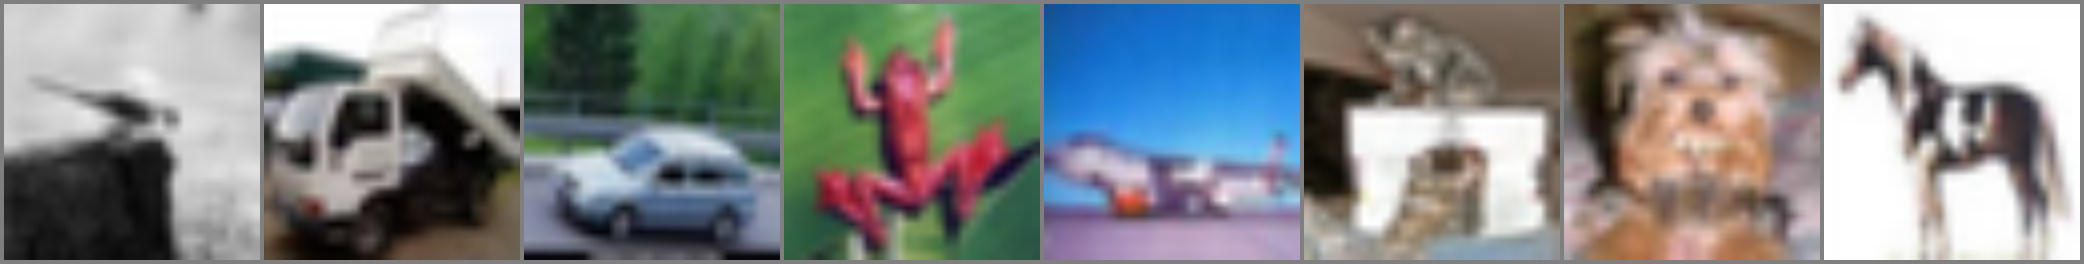

In [58]:
reverse_transform(make_grid(sample_images, nrow=8, padding=4))

## Build the architecture

In [47]:
class TransformerPositionalEmbedding(nn.Module):
    def __init__(self, dimension, max_timesteps=1000):
        super(TransformerPositionalEmbedding, self).__init__()

        assert dimension % 2 == 0, "Embedding dimension must be even"
        self.dimension = dimension

        self.pos_embd_matrix = torch.zeros(max_timesteps, dimension)
        even_indices = torch.arange(0, self.dimension, 2)

        log_term = torch.log(torch.tensor(10000.0)) / self.dimension
        div_term = torch.exp(even_indices * -log_term)

        timesteps = torch.arange(max_timesteps).unsqueeze(1)

        self.pos_embd_matrix[:, 0::2] = torch.sin(timesteps * div_term)
        self.pos_embd_matrix[:, 1::2] = torch.cos(timesteps * div_term)

    def forward(self, timestep):
        return self.pos_embd_matrix.to(timestep.device)[timestep]

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8, debug=False):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(groups, out_channels)
        self.act = nn.SiLU()

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[ConvBlock] Input")
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        self._debug_print(x, "[ConvBlock] Output")
        return x

In [103]:
_ = ConvBlock(3, 16, debug=True)(torch.randn(2, 3, 32, 32))

[ConvBlock] Input: torch.Size([2, 3, 32, 32])

[ConvBlock] Output: torch.Size([2, 16, 32, 32])

In [10]:
class ResNetBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        time_embd_channels=None,
        n_groups=8,
        debug=False,
    ):
        super(ResNetBlock, self).__init__()

        self.time_projection = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_embd_channels, out_channels) if time_embd_channels else None,
        )

        self.block1 = ConvBlock(in_channels, out_channels, groups=n_groups)
        self.block2 = ConvBlock(out_channels, out_channels, groups=n_groups)
        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, time_embd=None):
        input = x
        self._debug_print(input, "[ResNetBlock] Input")

        h = self.block1(x)
        self._debug_print(h, "[ResNetBlock] Block1")

        # Add time embedding after the first block
        time_embd = self.time_projection(time_embd)
        time_embd = time_embd[:, :, None, None]
        x = h + time_embd

        self._debug_print(x, "[ResNetBlock] Time projection")

        x = self.block2(x)
        self._debug_print(x, "[ResNetBlock] Block2")

        return x + self.residual_conv(input)


In [108]:
_ = ResNetBlock(16, 16, time_embd_channels=128, debug=True)(
    torch.randn(2, 16, 32, 32), torch.randn(2, 128)
)


[ResNetBlock] Input: torch.Size([2, 16, 32, 32])

[ResNetBlock] Block1: torch.Size([2, 16, 32, 32])

[ResNetBlock] Time projection: torch.Size([2, 16, 32, 32])

[ResNetBlock] Block2: torch.Size([2, 16, 32, 32])

In [11]:
class ConvDownBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        n_layers,
        time_embd_channels,
        n_groups,
        downsample=True,
        debug=False,
    ):
        super(ConvDownBlock, self).__init__()

        self.resnet_blocks = nn.ModuleList([])

        for i in range(n_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(
                in_channels,
                out_channels,
                time_embd_channels=time_embd_channels,
                n_groups=n_groups,
            )
            self.resnet_blocks.append(resnet_block)

        self.downsample = (
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            if downsample
            else None
        )
        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, time_embd):
        self._debug_print(x, "[ConvDownBlock] Input")

        for ix, block in enumerate(self.resnet_blocks):
            x = block(x, time_embd)
            self._debug_print(x, f"[ConvDownBlock] Block {ix}")

        if self.downsample:
            x = self.downsample(x)
            self._debug_print(x, "[ConvDownBlock] Downsample")

        return x


In [111]:
_ = ConvDownBlock(16, 32, 2, 128, 8, debug=True)(
    torch.randn(2, 16, 32, 32), torch.randn(2, 128)
)


[ConvDownBlock] Input: torch.Size([2, 16, 32, 32])

[ConvDownBlock] Block 0: torch.Size([2, 32, 32, 32])

[ConvDownBlock] Block 1: torch.Size([2, 32, 32, 32])

[ConvDownBlock] Downsample: torch.Size([2, 32, 16, 16])

In [12]:
class ConvUpBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        n_layers,
        time_embd_channels,
        n_groups,
        upsample=True,
        scale_factor=2.0,
        debug=False,
    ):
        super(ConvUpBlock, self).__init__()

        self.resnet_blocks = nn.ModuleList([])

        for i in range(n_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(
                in_channels,
                out_channels,
                time_embd_channels=time_embd_channels,
                n_groups=n_groups,
            )
            self.resnet_blocks.append(resnet_block)

        self.upsample = (
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            if upsample
            else None
        )
        self.scale_factor = scale_factor
        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, time_embd):
        self._debug_print(x, "[ConvUpBlock] Input")

        for ix, block in enumerate(self.resnet_blocks):
            x = block(x, time_embd)
            self._debug_print(x, f"[ConvUpBlock] Block {ix}")

        if self.upsample:
            x = F.interpolate(
                x, scale_factor=self.scale_factor, mode="bilinear", align_corners=True
            )
            x = self.upsample(x)
            self._debug_print(x, "[ConvUpBlock] Upsample")

        return x


In [114]:
_ = ConvUpBlock(32, 16, 2, 128, 8, debug=True)(
    torch.randn(2, 32, 32, 32), torch.randn(2, 128)
)

[ConvUpBlock] Input: torch.Size([2, 32, 32, 32])

[ConvUpBlock] Block 0: torch.Size([2, 16, 32, 32])

[ConvUpBlock] Block 1: torch.Size([2, 16, 32, 32])

[ConvUpBlock] Upsample: torch.Size([2, 16, 64, 64])

In [13]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, n_heads, in_channels, d_embd=256, n_groups=32, debug=False):
        super(SelfAttentionBlock, self).__init__()

        self.n_heads = n_heads
        self.d_embd = d_embd
        self.d_head = d_embd // n_heads
        self.scale = self.d_head**-0.5

        self.qkv = nn.Linear(in_channels, d_embd * 3)
        self.proj = nn.Linear(d_embd, d_embd)
        self.norm = nn.GroupNorm(n_groups, d_embd)

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[SelfAttentionBlock] Input")

        inp = x

        b, c, h, w = inp.shape

        inp = einops.rearrange(inp, "b c h w -> b (h w) c")
        self._debug_print(inp, "[SelfAttentionBlock] Rearrange")

        qkv = self.qkv(inp).chunk(3, dim=-1)

        q, k, v = map(
            lambda t: einops.rearrange(t, "b n (h d) -> b h n d", h=self.n_heads),
            qkv,
        )

        self._debug_print(q, "[SelfAttentionBlock] Q")
        self._debug_print(k, "[SelfAttentionBlock] K")
        self._debug_print(v, "[SelfAttentionBlock] V")

        dots = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        attn = dots.softmax(dim=-1)
        self._debug_print(attn, "[SelfAttentionBlock] Attention")

        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = einops.rearrange(out, "b h n d -> b n (h d)")
        self._debug_print(out, "[SelfAttentionBlock] Out")

        proj = self.proj(out)
        proj = einops.rearrange(proj, "b (h w) c -> b c h w", h=h, w=w)
        self._debug_print(proj, "[SelfAttentionBlock] Projection")

        x = self.norm(proj + x)
        self._debug_print(x, "[SelfAttentionBlock] Output")
        return x


In [158]:
_ = SelfAttentionBlock(8, 256, d_embd=256, debug=True)(torch.randn(2, 256, 32, 32))

[SelfAttentionBlock] Input: torch.Size([2, 256, 32, 32])

[SelfAttentionBlock] Rearrange: torch.Size([2, 1024, 256])

[SelfAttentionBlock] Q: torch.Size([2, 8, 1024, 32])

[SelfAttentionBlock] K: torch.Size([2, 8, 1024, 32])

[SelfAttentionBlock] V: torch.Size([2, 8, 1024, 32])

[SelfAttentionBlock] Attention: torch.Size([2, 8, 1024, 1024])

[SelfAttentionBlock] Out: torch.Size([2, 1024, 256])

[SelfAttentionBlock] Projection: torch.Size([2, 256, 32, 32])

[SelfAttentionBlock] Output: torch.Size([2, 256, 32, 32])

In [14]:
class AttentionDownBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        n_layers,
        n_heads,
        n_groups,
        time_embd_channels,
        downsample=True,
        debug=False,
    ):
        super(AttentionDownBlock, self).__init__()

        self.resnet_blocks = nn.ModuleList([])
        self.attn_blocks = nn.ModuleList([])

        for i in range(n_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(
                in_channels,
                out_channels,
                time_embd_channels=time_embd_channels,
                n_groups=n_groups,
            )

            attn_block = SelfAttentionBlock(
                n_heads,
                in_channels=out_channels,
                d_embd=out_channels,
                n_groups=n_groups,
            )
            self.resnet_blocks.append(resnet_block)
            self.attn_blocks.append(attn_block)

        self.downsample = (
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            if downsample
            else None
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, time_embd):
        for ix, (resnet_block, attn_block) in enumerate(
            zip(self.resnet_blocks, self.attn_blocks)
        ):
            x = resnet_block(x, time_embd)
            self._debug_print(x, f"[AttentionDownBlock] ResNet Block {ix}")

            x = attn_block(x)
            self._debug_print(x, f"[AttentionDownBlock] Attention Block {ix}")

        if self.downsample:
            x = self.downsample(x)
            self._debug_print(x, "[AttentionDownBlock] Downsample")

        return x


In [160]:
_ = AttentionDownBlock(16, 32, 2, 8, 32, 128, downsample=True, debug=True)(
    torch.randn(2, 16, 32, 32), torch.randn(2, 128)
)


[AttentionDownBlock] ResNet Block 0: torch.Size([2, 32, 32, 32])

[AttentionDownBlock] Attention Block 0: torch.Size([2, 32, 32, 32])

[AttentionDownBlock] ResNet Block 1: torch.Size([2, 32, 32, 32])

[AttentionDownBlock] Attention Block 1: torch.Size([2, 32, 32, 32])

[AttentionDownBlock] Downsample: torch.Size([2, 32, 16, 16])

In [15]:
class AttentionUpBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        n_layers,
        n_heads,
        n_groups,
        time_embd_channels,
        upsample=True,
        scale_factor=2.0,
        debug=False,
    ):
        super(AttentionUpBlock, self).__init__()

        self.resnet_blocks = nn.ModuleList([])
        self.attn_blocks = nn.ModuleList([])

        for i in range(n_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(
                in_channels,
                out_channels,
                time_embd_channels=time_embd_channels,
                n_groups=n_groups,
            )

            attn_block = SelfAttentionBlock(
                n_heads,
                in_channels=out_channels,
                d_embd=out_channels,
                n_groups=n_groups,
            )
            self.resnet_blocks.append(resnet_block)
            self.attn_blocks.append(attn_block)

        self.upsample = (
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            if upsample
            else None
        )
        self.scale_factor = scale_factor

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, time_embd):
        for ix, (resnet_block, attn_block) in enumerate(
            zip(self.resnet_blocks, self.attn_blocks)
        ):
            x = resnet_block(x, time_embd)
            self._debug_print(x, f"[AttentionUpBlock] ResNet Block {ix}")

            x = attn_block(x)
            self._debug_print(x, f"[AttentionUpBlock] Attention Block {ix}")

        if self.upsample:
            x = F.interpolate(
                x, scale_factor=self.scale_factor, mode="bilinear", align_corners=True
            )
            x = self.upsample(x)
            self._debug_print(x, "[AttentionUpBlock] Upsample")

        return x

In [163]:
_ = AttentionUpBlock(32, 16, 2, 8, 8, 128, upsample=True, debug=True)(
    torch.randn(2, 32, 32, 32), torch.randn(2, 128)
)


[AttentionUpBlock] ResNet Block 0: torch.Size([2, 16, 32, 32])

[AttentionUpBlock] Attention Block 0: torch.Size([2, 16, 32, 32])

[AttentionUpBlock] ResNet Block 1: torch.Size([2, 16, 32, 32])

[AttentionUpBlock] Attention Block 1: torch.Size([2, 16, 32, 32])

[AttentionUpBlock] Upsample: torch.Size([2, 16, 64, 64])

In [48]:
class Unet(nn.Module):
    def __init__(
        self,
        image_size=256,
        in_channels=3,
        base_channels=128,
        n_layers=2,
        n_heads=4,
        n_groups=32,
        debug=False,
    ):
        super(Unet, self).__init__()

        self.image_size = image_size
        self.base_channels = base_channels

        self.initial_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=self.base_channels,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.time_embd_channels = self.base_channels * 4

        self.n_layers = n_layers
        self.n_heads = n_heads
        self.n_groups = n_groups

        self.positional_encoding = nn.Sequential(
            TransformerPositionalEmbedding(self.base_channels),
            nn.Linear(self.base_channels, self.time_embd_channels),
            nn.GELU(),
            nn.Linear(self.time_embd_channels, self.time_embd_channels),
        )

        self.downsample_blocks = nn.ModuleList(
            [
                ConvDownBlock(
                    in_channels=self.base_channels,
                    out_channels=self.base_channels,
                    n_layers=self.n_layers,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
                ConvDownBlock(
                    in_channels=self.base_channels,
                    out_channels=self.base_channels,
                    n_layers=self.n_layers,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
                ConvDownBlock(
                    in_channels=self.base_channels,
                    out_channels=self.base_channels * 2,
                    n_layers=self.n_layers,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
                AttentionDownBlock(
                    in_channels=self.base_channels * 2,
                    out_channels=self.base_channels * 2,
                    n_layers=self.n_layers,
                    n_heads=self.n_heads,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
                ConvDownBlock(
                    in_channels=self.base_channels * 2,
                    out_channels=self.base_channels * 4,
                    n_layers=self.n_layers,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
            ]
        )

        self.bottleneck = AttentionDownBlock(
            in_channels=self.base_channels * 4,
            out_channels=self.base_channels * 4,
            n_layers=self.n_layers,
            n_heads=self.n_heads,
            n_groups=self.n_groups,
            time_embd_channels=self.time_embd_channels,
            downsample=False,
        )

        self.upsample_blocks = nn.ModuleList(
            [
                ConvUpBlock(
                    in_channels=self.base_channels * 4 + self.base_channels * 4,
                    out_channels=self.base_channels * 4,
                    n_layers=self.n_layers,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
                AttentionUpBlock(
                    in_channels=self.base_channels * 4 + self.base_channels * 2,
                    out_channels=self.base_channels * 2,
                    n_layers=self.n_layers,
                    n_heads=self.n_heads,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
                ConvUpBlock(
                    in_channels=self.base_channels * 2 + self.base_channels * 2,
                    out_channels=self.base_channels * 2,
                    n_layers=self.n_layers,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
                ConvUpBlock(
                    in_channels=self.base_channels * 2 + self.base_channels,
                    out_channels=self.base_channels,
                    n_layers=self.n_layers,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
                ConvUpBlock(
                    in_channels=self.base_channels + self.base_channels,
                    out_channels=self.base_channels,
                    n_layers=self.n_layers,
                    n_groups=self.n_groups,
                    time_embd_channels=self.time_embd_channels,
                ),
            ]
        )

        self.output_conv = nn.Sequential(
            nn.GroupNorm(num_groups=self.n_groups, num_channels=self.base_channels * 2),
            nn.SiLU(),
            nn.Conv2d(
                in_channels=self.base_channels * 2,
                out_channels=in_channels,
                kernel_size=3,
                padding=1,
            ),
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, timestep):
        self._debug_print(x, "[Unet] Input")

        t_encoded = self.positional_encoding(timestep)
        self._debug_print(t_encoded, "[Unet] Time Encoding")

        init_x = self.initial_conv(x)
        self._debug_print(init_x, "[Unet] Initial Conv")

        skip_connections = [init_x]

        x = init_x
        for ix, block in enumerate(self.downsample_blocks):
            x = block(x, t_encoded)
            self._debug_print(x, f"[Unet] Downsample Block {ix}")
            skip_connections.append(x)

        skip_connections = skip_connections[::-1]

        x = self.bottleneck(x, t_encoded)
        self._debug_print(x, "[Unet] Bottleneck")

        for ix, (block, skip) in enumerate(zip(self.upsample_blocks, skip_connections)):
            x = torch.cat([x, skip], dim=1)
            self._debug_print(x, f"[Unet] Concatenation {ix}")

            x = block(x, t_encoded)
            self._debug_print(x, f"[Unet] Upsample Block {ix}")

        x = torch.cat([x, skip_connections[-1]], dim=1)
        self._debug_print(x, "[Unet] Final Concatenation")
        x = self.output_conv(x)
        self._debug_print(x, "[Unet] Output")

        return x


In [17]:
_ = Unet(
    image_size=256,
    in_channels=3,
    base_channels=128,
    n_layers=2,
    n_heads=4,
    n_groups=32,
    debug=True,
)(torch.randn(2, 3, 256, 256), torch.tensor(0).unsqueeze(0))

[Unet] Input: torch.Size([2, 3, 256, 256])

[Unet] Time Encoding: torch.Size([1, 512])

[Unet] Initial Conv: torch.Size([2, 128, 256, 256])

[Unet] Downsample Block 0: torch.Size([2, 128, 128, 128])

[Unet] Downsample Block 1: torch.Size([2, 128, 64, 64])

[Unet] Downsample Block 2: torch.Size([2, 256, 32, 32])

[Unet] Downsample Block 3: torch.Size([2, 256, 16, 16])

[Unet] Downsample Block 4: torch.Size([2, 512, 8, 8])

[Unet] Bottleneck: torch.Size([2, 512, 8, 8])

[Unet] Concatenation 0: torch.Size([2, 1024, 8, 8])

[Unet] Upsample Block 0: torch.Size([2, 512, 16, 16])

[Unet] Concatenation 1: torch.Size([2, 768, 16, 16])

[Unet] Upsample Block 1: torch.Size([2, 256, 32, 32])

[Unet] Concatenation 2: torch.Size([2, 512, 32, 32])

[Unet] Upsample Block 2: torch.Size([2, 256, 64, 64])

[Unet] Concatenation 3: torch.Size([2, 384, 64, 64])

[Unet] Upsample Block 3: torch.Size([2, 128, 128, 128])

[Unet] Concatenation 4: torch.Size([2, 256, 128, 128])

[Unet] Upsample Block 4: torch.Size([2, 128, 256, 256])

[Unet] Final Concatenation: torch.Size([2, 256, 256, 256])

[Unet] Output: torch.Size([2, 3, 256, 256])

In [49]:
class DDPMPipeline(nn.Module):
    def __init__(self, beta_start=1e-4, beta_end=1e-2, n_timesteps=1000):
        super(DDPMPipeline, self).__init__()

        self.betas = torch.linspace(beta_start, beta_end, n_timesteps)
        self.alphas = 1 - self.betas

        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

        self.n_timesteps = n_timesteps

    def forward(self, x, t):
        eta = torch.randn_like(x).to(x.device)

        alpha_hat = self.alphas_hat.to(x.device)[t]

        return alpha_hat.sqrt() * x + (1 - alpha_hat).sqrt() * eta, eta

    def backward(self, model, noisy_x, t):
        noise_hat = model(noisy_x, t)
        return noise_hat


In [60]:
model = Unet(
    image_size=256,
    in_channels=3,
).to(device)

total_param_count = sum(p.numel() for p in model.parameters())
print(f"Total parameter count: {total_param_count / 1e6:.3f}M")


optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer, T_max=len(train_loader) * N_EPOCHS, last_epoch=-1, eta_min=1e-9
)

loss_fn = nn.MSELoss()


Total parameter count: 58.661M

In [61]:
pipeline = DDPMPipeline(n_timesteps=N_TIMESTEPS).to(device)

In [63]:
for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    model.train()
    train_loss = 0.0

    for ix, (images, _) in enumerate(tqdm(train_loader, desc="Batches", leave=False)):
        images = images.to(device)
        batch_size = images.size(0)

        t = torch.randint(0, N_TIMESTEPS, size=(1,)).to(device).long()
        print(t.shape)

        noisy_x, eta = pipeline(images, t)
        noisy_x = noisy_x.to(device)

        noise_hat = pipeline.backward(model, noisy_x, t)
        loss = loss_fn(noise_hat, eta)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()
        break

    train_loss /= len(train_loader)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.5f}")
    break


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

Batches:   0%|          | 0/6250 [00:00<?, ?it/s]

torch.Size([1])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:15                                                                                   │
│                                                                                                  │
│   12 │   │   noisy_x, eta = pipeline(images, t)                                                  │
│   13 │   │   noisy_x = noisy_x.to(device)                                                        │
│   14 │   │                                                                                       │
│ ❱ 15 │   │   noise_hat = pipeline.backward(model, noisy_x, t)                                    │
│   16 │   │   loss = loss_fn(noise_hat, eta)                                                      │
│   17 │   │                                                                                       │
│   18 │   │   optimizer.zero_grad()                                                               │
│                                                                                                  │
│ in backward:20                                                                                   │
│                                                                                                  │
│   17 │   │   return alpha_hat.sqrt() * x + (1 - alpha_hat).sqrt() * eta, eta                     │
│   18 │                                                                                           │
│   19 │   def backward(self, model, noisy_x, t):                                                  │
│ ❱ 20 │   │   noise_hat = model(noisy_x, t)                                                       │
│   21 │   │   return noise_hat                                                                    │
│   22                                                                                             │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\nn\modules\module.py:1532 in     │
│ _wrapped_call_impl                                                                               │
│                                                                                                  │
│   1529 │   │   if self._compiled_call_impl is not None:                                          │
│   1530 │   │   │   return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]        │
│   1531 │   │   else:                                                                             │
│ ❱ 1532 │   │   │   return self._call_impl(*args, **kwargs)                                       │
│   1533 │                                                                                         │
│   1534 │   def _call_impl(self, *args, **kwargs):                                                │
│   1535 │   │   forward_call = (self._slow_forward if torch._C._get_tracing_state() else self.fo  │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\nn\modules\module.py:1541 in     │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1538 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1539 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1540 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1541 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1542 │   │                                                                                     │
│   1543 │   │   try:                                        